In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


from DMS2_multiday_plots_utils import *
from DMS2_fetch_protocol_data import fetch_latest_trials_data
from dj_utils import return_date_window
# settings
%load_ext autoreload
%autoreload 2


sns.set_context("talk")
# ratinfo = dj.create_virtual_module("intfo", "ratinfo")

from DMS2_fetch_daily_summary_data import fetch_daily_summary_info

[2023-05-31 12:45:05,092][INFO]: Connecting jbreda@bdata00.pni.princeton.edu:3306
[2023-05-31 12:45:05,299][INFO]: Connected jbreda@bdata00.pni.princeton.edu:3306


TODO:
* trial results bar plot -> function (stacked or unstacked option)
* compose mega-figure

semi urgent extras:
* pre_go/can_viol daily plot

less urgent extras:
* update float dtypes to be pyarrow
* write an ax.utils function for x ticks, legend and title to allow for single line calls

In [4]:
date_min, date_max = return_date_window(latest_date=None, n_days_back=5)

In [9]:
df = fetch_latest_trials_data(
    animal_ids=None, 
    date_min=date_min, 
    date_max=date_max
)
r610 = df.query("animal_id == 'R610'")

fetched 6 sessions for R610 between 2023-05-20 and 2023-05-25
fetched 6 sessions for R611 between 2023-05-20 and 2023-05-25
fetched 6 sessions for R612 between 2023-05-20 and 2023-05-25
fetched 6 sessions for R613 between 2023-05-20 and 2023-05-25
fetched 6 sessions for R614 between 2023-05-20 and 2023-05-25


In [10]:
sum_df = fetch_daily_summary_info(animal_ids=["R610"], date_min="2023-05-15")
sum_r610 = sum_df.query("animal_id == 'R610'")


fetched 11 daily summaries for R610 between 2023-05-15 and 2023-05-25


In [10]:
# # df.to_csv('df.csv', index=False) # already ran this
# df = pd.read_csv('df.csv') # run if needed
# r610 = df.query("animal_id == 'R610'")

# sum_df = pd.read_csv('summary_df.csv')
# sum_r610 = sum_df.query("animal_id == 'R610'")

## Trials Plot

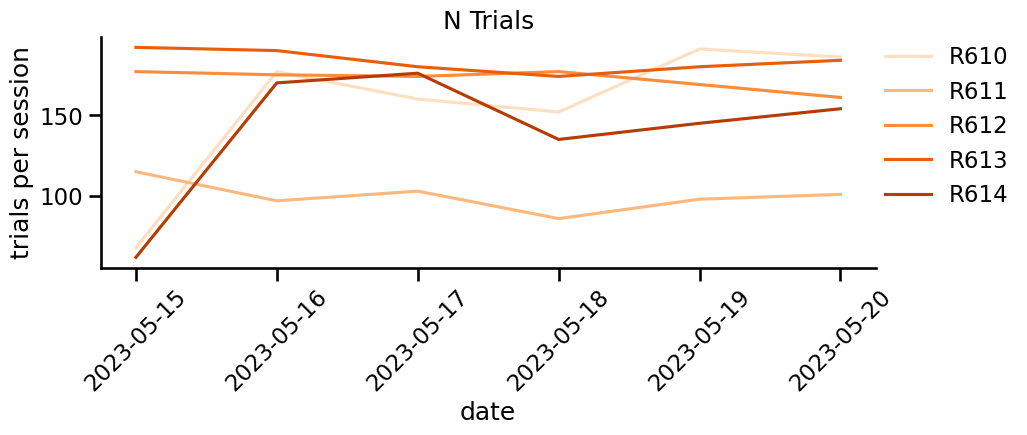

In [11]:
fig,ax = create_figure()
plot_multianimal_trials(df, ax)


35


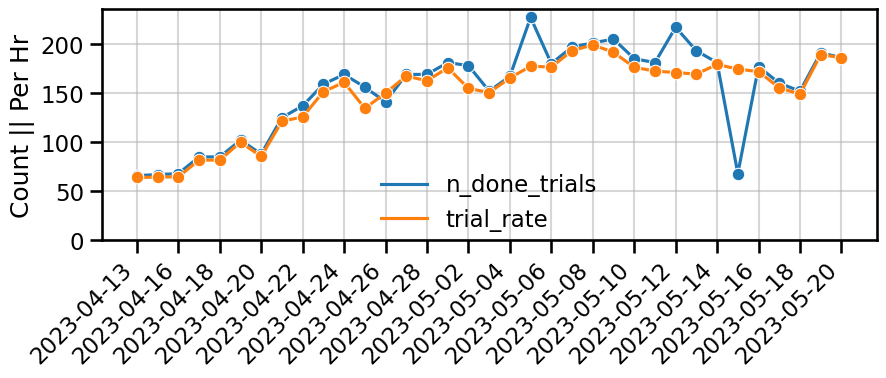

In [12]:
fig, ax = create_figure()

plot_multiday_trials(sum_r610 , ax,legend=True)

## Stage plots

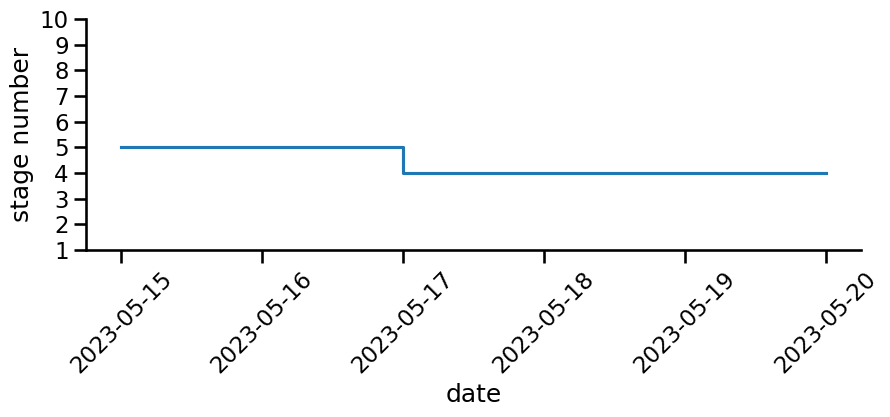

In [13]:
afig,ax = create_figure()
plot_stage(r610, ax)

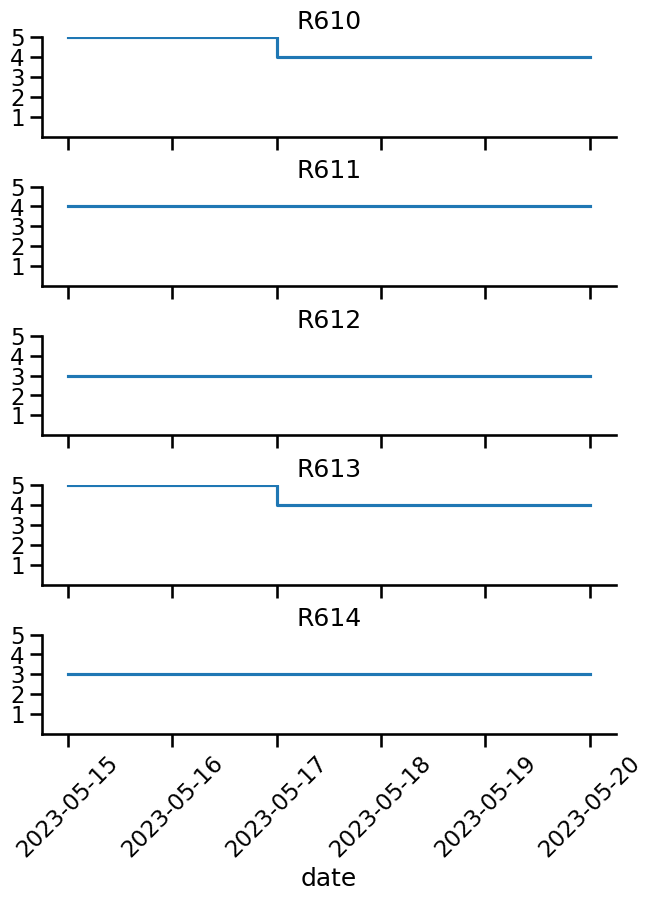

In [14]:
fig,ax=plt.subplots(5,1, figsize=(7,8), sharey=True, sharex=True)
plt.tight_layout()
for ii, (animal_id,sub_df) in enumerate(df.groupby("animal_id")):
    plot_stage(sub_df, ax[ii])
    ax[ii].set(ylim=(0,5), ylabel="", title=animal_id)

## Bias Plots

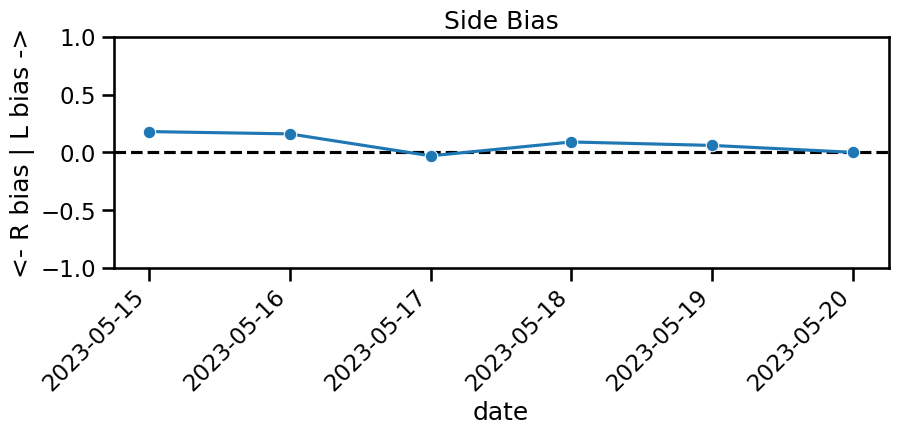

In [15]:
fig,ax = create_figure()
plot_multiday_side_bias(r610, ax)


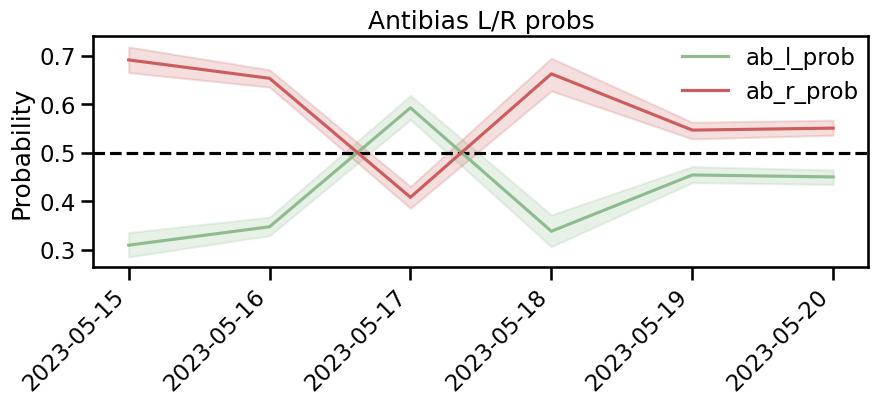

In [16]:
fig,ax = plt.subplots(figsize=(10,3))

plot_multiday_antibias_probs(r610, ax)

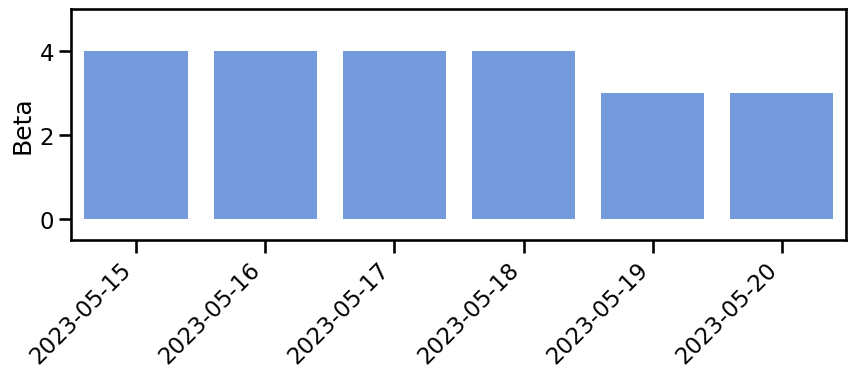

In [17]:
fig,ax = create_figure()

plot_multiday_antibias_beta(r610, ax)

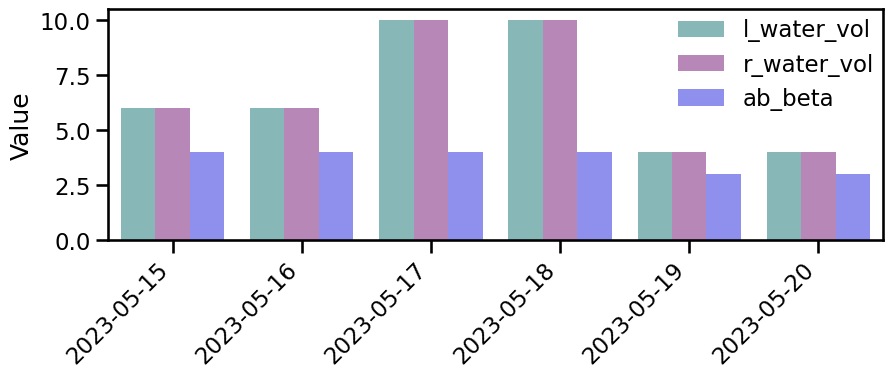

In [18]:
fig,ax= create_figure()

plot_multiday_sidebias_params(r610, ax, legend=True)


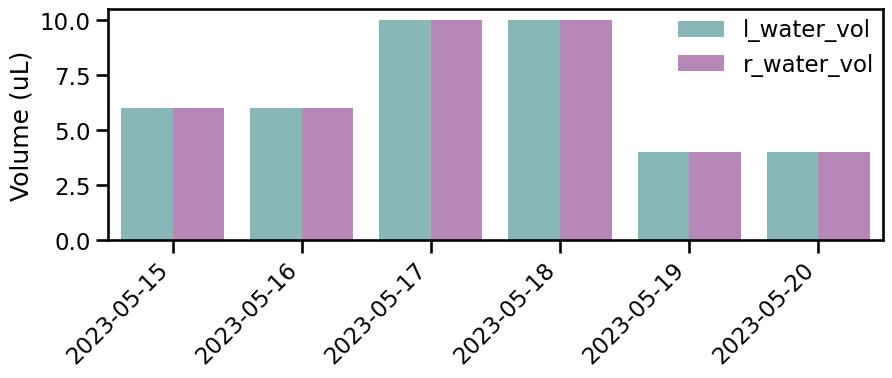

In [20]:
fig,ax = create_figure()
plot_multiday_water_vols(r610, ax)

## Water & Mass plots

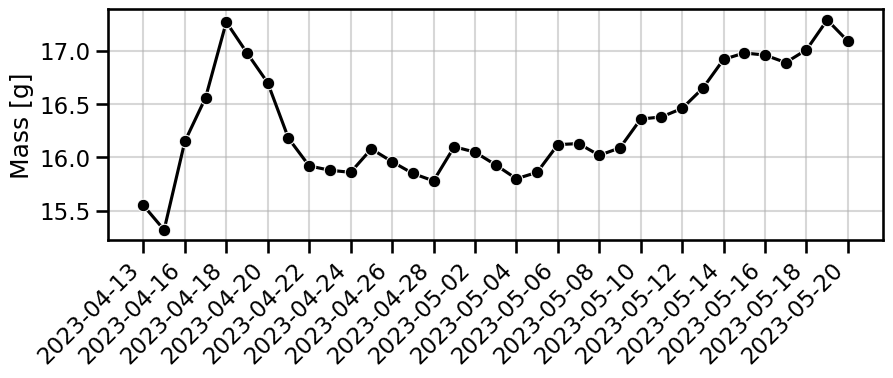

In [21]:
fig,ax = create_figure()
plot_multiday_mass(sum_r610, ax)


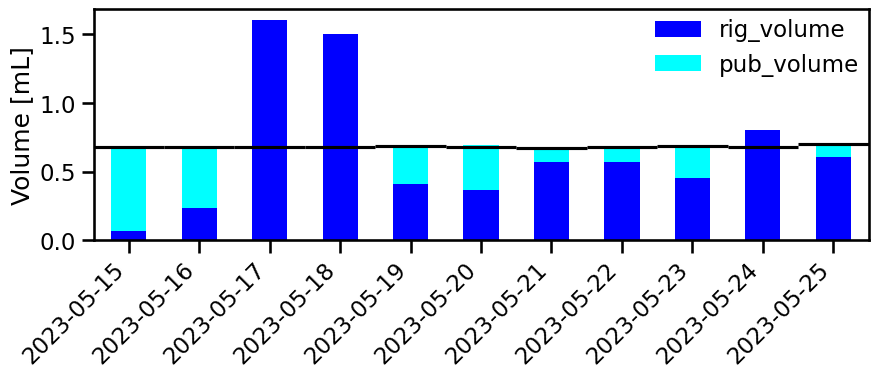

In [31]:
# test plot_multiday_water_restriction
fig,ax = create_figure()
plot_multiday_water_restriction(sum_r610, ax)

## Trial result plot

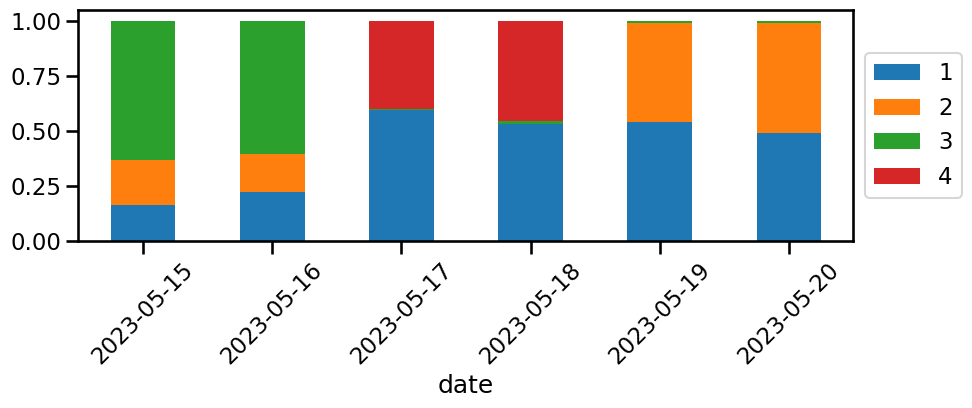

In [23]:
# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 3))
y = r610.groupby(["date"]).result.value_counts(normalize=True).unstack()
y.plot(kind='bar', stacked=True, ax=ax)

# Rotate x-axis labels
ax.tick_params(axis="x", labelrotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

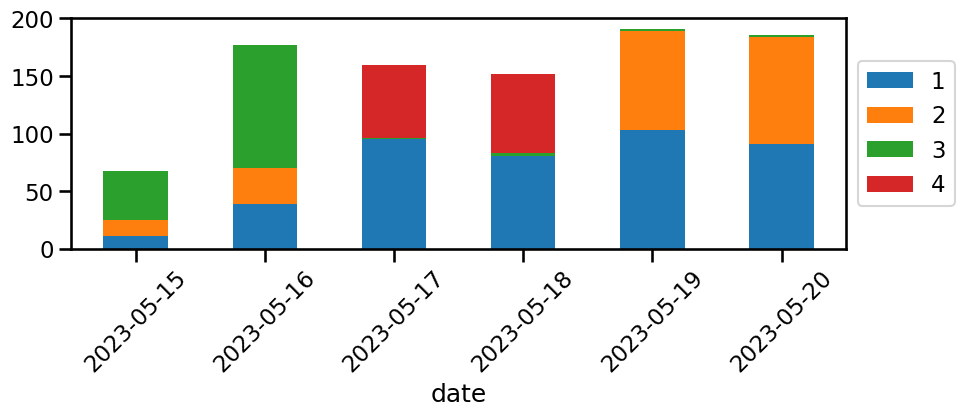

In [24]:
z = r610.groupby(["date"]).result.value_counts().unstack()
fig, ax = plt.subplots(figsize=(10, 3))
z.plot(kind='bar', stacked=True, ax=ax)

# Rotate x-axis labels
ax.tick_params(axis="x", labelrotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

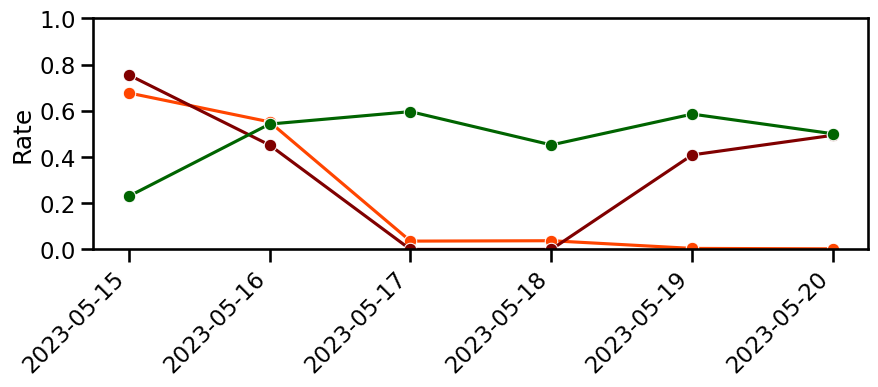

In [25]:
fig,ax = plt.subplots(figsize =(10,3))

plot_multiday_perfs(r610, ax)


## Timing Params

-pre_go, viol_dur, delay_dur (all on one plot?)
- cumulative delay_dur, colored by was_violation or was_noanswers

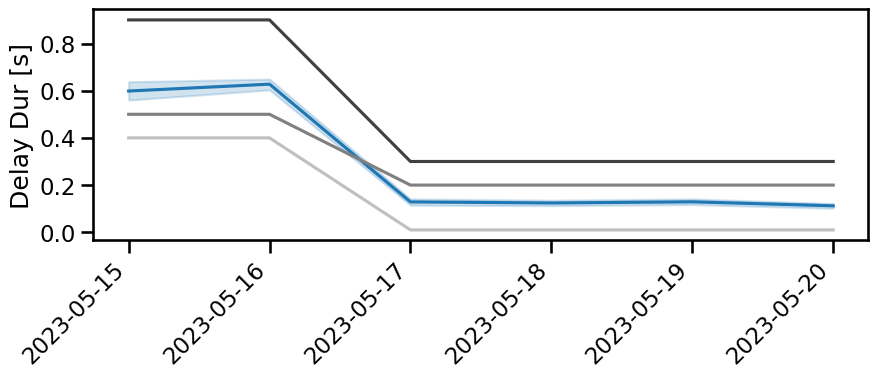

In [26]:
fig, ax = create_figure()

plot_multiday_delay_params(r610, ax)

## Rig & Tech

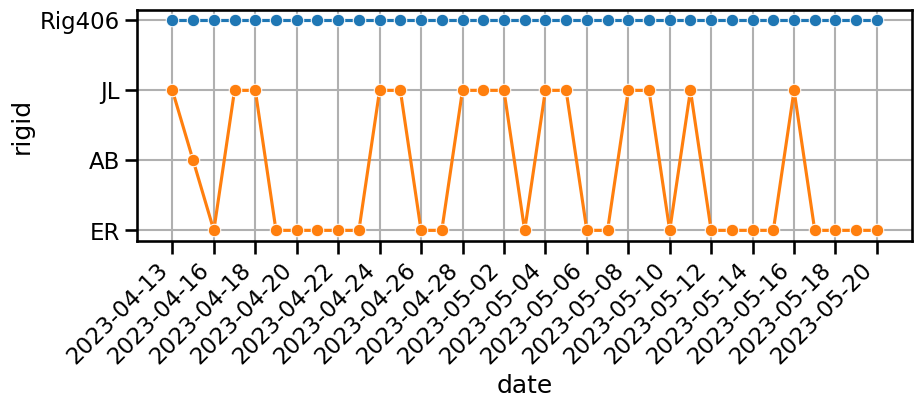

In [27]:
fig,ax = create_figure()
# TODO make this into a function

sns.lineplot(data=sum_r610, x="date", y="rigid", marker="o",ax=ax)
sns.lineplot(data=sum_r610, x="date", y="tech",marker="o",ax=ax)

ax.tick_params(axis="x", labelrotation=45)
set_date_x_ticks(ax, len(sum_r610.date))
ax.grid()


### Poking Info


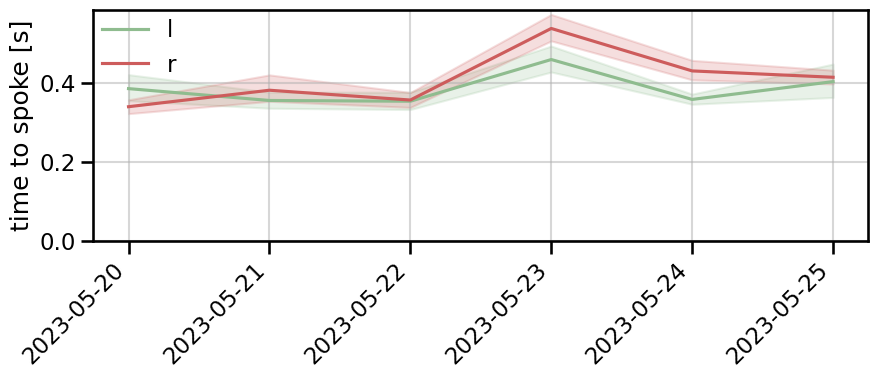

In [43]:
fig, ax= create_figure()
plot_multiday_time_to_spoke(r610, ax)

In [32]:
ax.get_xticklabels()

[Text(0, 0, '2023-05-15'),
 Text(1, 0, '2023-05-16'),
 Text(2, 0, '2023-05-17'),
 Text(3, 0, '2023-05-18'),
 Text(4, 0, '2023-05-19'),
 Text(5, 0, '2023-05-20'),
 Text(6, 0, '2023-05-21'),
 Text(7, 0, '2023-05-22'),
 Text(8, 0, '2023-05-23'),
 Text(9, 0, '2023-05-24'),
 Text(10, 0, '2023-05-25')]